# Clasificador de píxeles en imágenes de dermatoscopía

## Uso de librerías

In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

## Entrada de datos

In [2]:
dataset_ruta = "./dataset"

def cargar_imagenes_dermastocopia(ruta):
    path = Path(ruta)
    files = sorted([f.name for f in path.iterdir() if f.is_file()])

    imagenes_binarias = [f for f in files if "_expert" in f and f.endswith(".png")]
    imagenes_originales = [
        f for f in files if "_expert" not in f and f.endswith(".jpg")
    ]

    print(
        f"Se han cargado {len(imagenes_originales)} imágenes originales y {len(imagenes_binarias)} imágenes binarias."
    )

    return imagenes_originales, imagenes_binarias

img_base, img_mask = cargar_imagenes_dermastocopia(dataset_ruta)

Se han cargado 150 imágenes originales y 150 imágenes binarias.


## Partición de datos

In [3]:
def dividir_dataset(img_base, img_mask, test_ratio=0.15, val_ratio=0.15):
    train_ratio = 1 - test_ratio - val_ratio
    pares = []
    for base in img_base:
        name = base.split(".")[0]
        mask = f"{name}_expert.png"

        if mask in img_mask:
            pares.append((base, mask))

    print(f"Total de pares encontrados: {len(pares)}")

    pares_arr = np.array(pares)
    seed = 42
    np.random.seed(seed)
    np.random.shuffle(pares_arr)
    n = len(pares_arr)

    # Índices para dividir
    n_test = int(n * test_ratio)
    n_val = int(n * val_ratio)
    n_train = n - n_test - n_val

    test_set = pares_arr[:n_test]
    val_set = pares_arr[n_test : n_test + n_val]

    train_set = pares_arr[n_test + n_val :]

    dataset = {
        "train": {
            "images": train_set[:, 0].tolist(),
            "masks": train_set[:, 1].tolist(),
            "count": len(train_set),
        },
        "val": {
            "images": val_set[:, 0].tolist(),
            "masks": val_set[:, 1].tolist(),
            "count": len(val_set),
        },
        "test": {
            "images": test_set[:, 0].tolist(),
            "masks": test_set[:, 1].tolist(),
            "count": len(test_set),
        },
        "seed": seed,
        "total": n,
    }

    print(f"\n=== DIVISIÓN DEL DATASET ===")
    print(f"Semilla utilizada: {seed}")
    print(f"Entrenamiento: {n_train} imágenes ({train_ratio*100:.1f}%)")
    print(f"Validación:    {n_val} imágenes ({val_ratio*100:.1f}%)")
    print(f"Prueba:        {n_test} imágenes ({test_ratio*100:.1f}%)")
    print(f"Total:         {n} imágenes")

    return dataset

dataset = dividir_dataset(img_base, img_mask)

Total de pares encontrados: 150

=== DIVISIÓN DEL DATASET ===
Semilla utilizada: 42
Entrenamiento: 106 imágenes (70.0%)
Validación:    22 imágenes (15.0%)
Prueba:        22 imágenes (15.0%)
Total:         150 imágenes


## Clasificador Bayesiano + PCA

In [4]:
from bayes_pca import ClasificadorPCA

clasificador = ClasificadorPCA()

# Cargar imágenes de entrenamiento (sin redimensionar)
print("\n=== CARGANDO IMÁGENES ===")
train_images, train_masks = clasificador.cargar_imagenes(dataset, dataset_ruta, 'train')

print("\n=== CARGANDO IMÁGENES DE VALIDACIÓN ===")
val_images, val_masks = clasificador.cargar_imagenes(dataset, dataset_ruta, 'val')

print("\n=== CARGANDO IMÁGENES DE PRUEBA ===")
test_images, test_masks = clasificador.cargar_imagenes(dataset, dataset_ruta, 'test')

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
# 3. Extraer características por separado
X_train, y_train = clasificador.extraer_caracteristicas_pixel(train_images, train_masks)
X_val, y_val = clasificador.extraer_caracteristicas_pixel(val_images, val_masks)
X_test, y_test = clasificador.extraer_caracteristicas_pixel(test_images, test_masks)
    

Extrayendo características: 106it [00:19,  5.37it/s]
Extrayendo características: 22it [00:04,  5.43it/s]
Extrayendo características: 22it [00:03,  5.61it/s]


In [ ]:
youden = clasificador.entrenar_con_validacion_externa(X_train, y_train, X_val, y_val)


Píxeles training: 106000
Píxeles validation: 22000
Componentes óptimas: 5, Youden: 0.763



=== VISUALIZACIONES ===


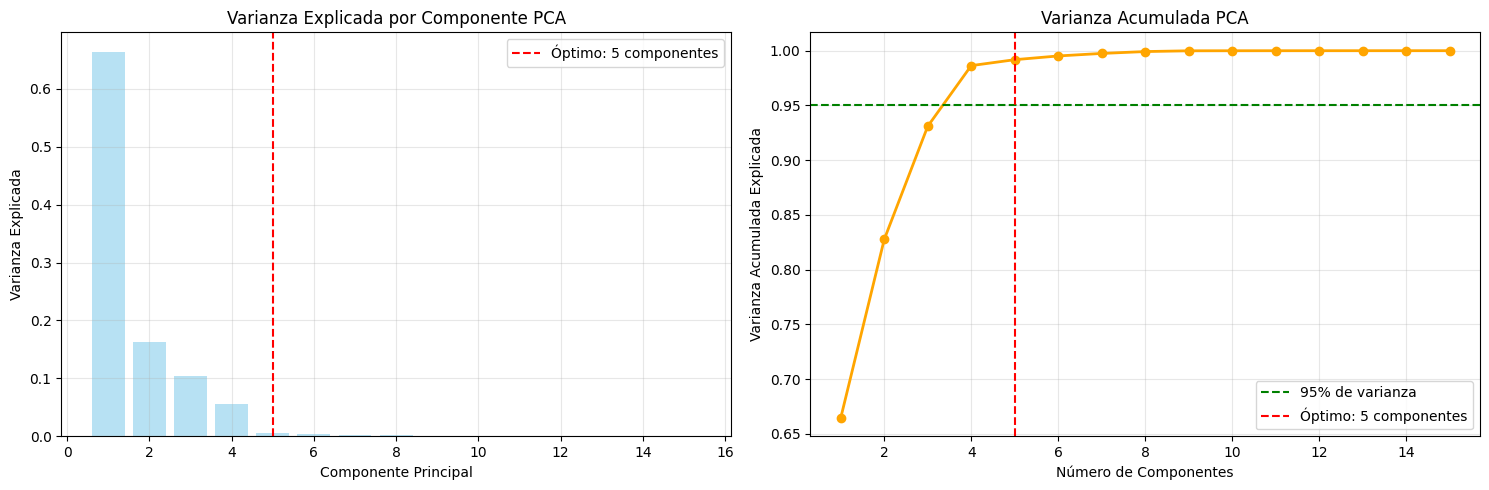

Varianza explicada por las primeras 5 componentes: 0.992


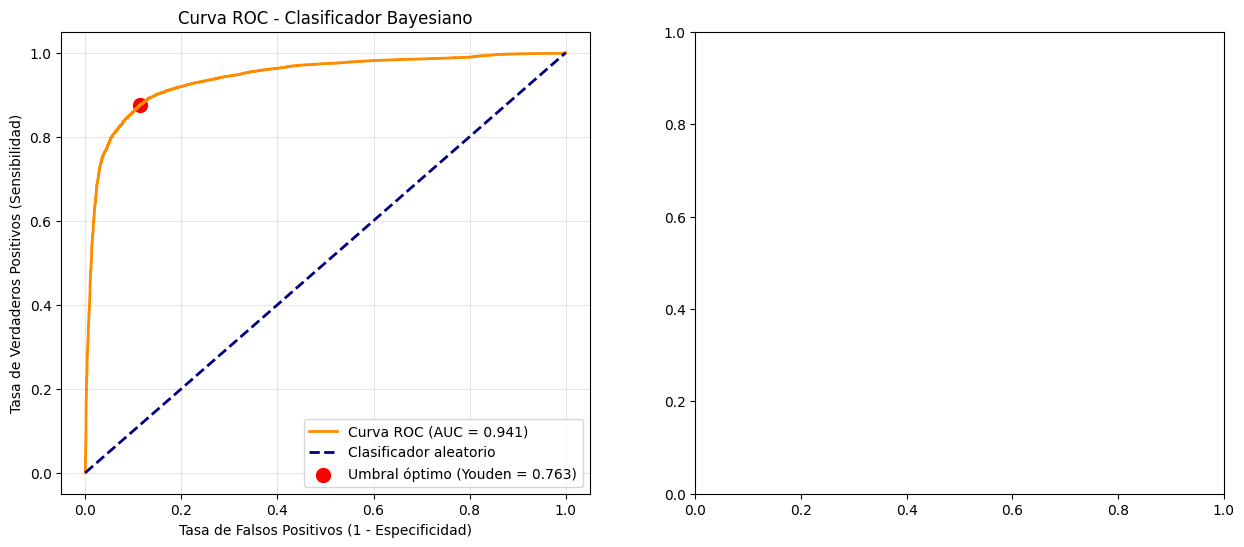

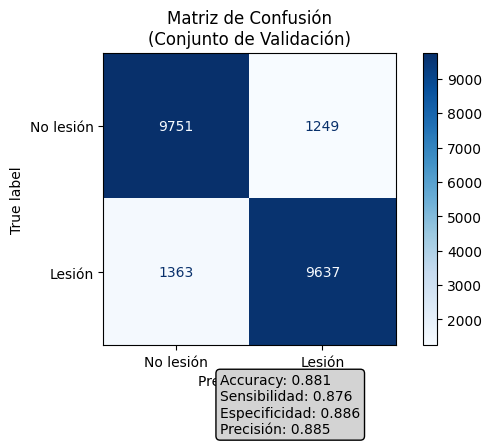


MÉTRICAS DETALLADAS - CONJUNTO DE VALIDACIÓN
Accuracy:    0.8813
Sensibilidad: 0.8761 (Capacidad de detectar lesiones)
Especificidad: 0.8865 (Capacidad de evitar falsos positivos)
Precisión:    0.8853 (Lesiones correctamente identificadas)
Índice de Youden: 0.7625
Umbral óptimo: 0.3332
AUC:         0.9412


In [ ]:
from bayes_pca import visualizar_pca, visualizar_auc_y_matriz_confusion, evaluar_en_test

print("\n=== VISUALIZACIONES ===")
    
# 1. Visualizar PCA
visualizar_pca(clasificador, X_train, y_train, X_val, y_val)
    
# 2. Visualizar AUC y Matriz de Confusión
roc_auc, cm = visualizar_auc_y_matriz_confusion(clasificador, X_val, y_val)

### Probar con el conjunto de prueba

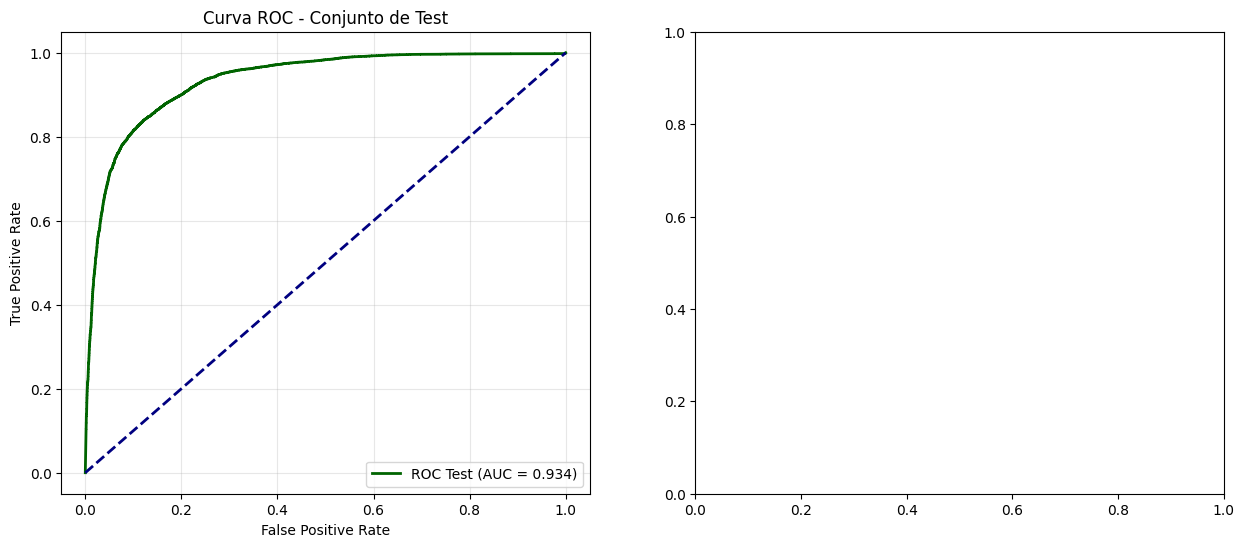

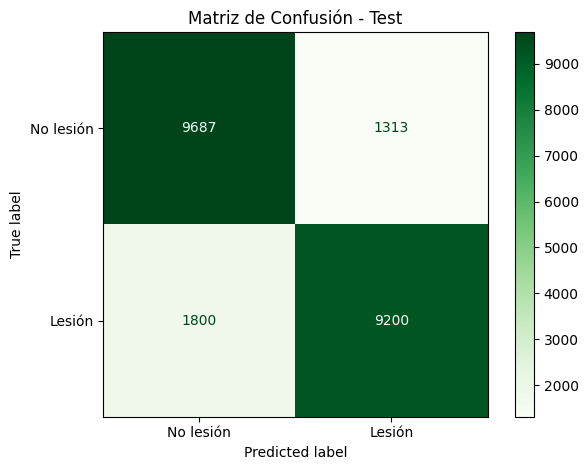

In [ ]:
X_test_std = clasificador.scaler.transform(X_test)
X_test_pca = clasificador.pca.transform(X_test_std)
X_test_opt = X_test_pca[:, :clasificador.optimal_components]
    
y_proba = clasificador._calcular_probabilidades(X_test_opt)
y_pred = (y_proba >= clasificador.optimal_threshold).astype(int)
    
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
cm = confusion_matrix(y_test, y_pred)
    
plt.figure(figsize=(15, 6))
    
# Curva ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkgreen', lw=2, label=f'ROC Test (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Conjunto de Test')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
    
# Matriz de Confusión
plt.subplot(1, 2, 2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No lesión', 'Lesión'])
disp.plot(cmap='Greens', values_format='d')
plt.title('Matriz de Confusión - Test')
    
plt.tight_layout()
plt.show()